# Malmquist bias
My sample is magnitude limited, and therefore subject to Malmquist bias. For a binary survey, the effect of Malmquist bias is to favor systems with large mass-ratios, since the companion has higher flux. Neglected all other sampling biases such as my vsini limit (which shouldn't introduce a strong bias), the probability of being in my sample is essentially:

\\[
P(obs) =
  \begin{cases}
    1 & \text{if } V < 6 \\
    0 & \text{otherwise}
  \end{cases}
\\]

Now V, the apparent V-band magnitude of the target, is of course a function of the distance ($\rho$) to the star and the absolute magnitude of the star:

$$ V = M_V + 5\log{\rho} - 5 $$

In the case of binary stars, the absolute magnitude is coming from the light of two stars with primary mass $M_1$ and companion mass $qM_1$:

$$ M_{v, total}(q, M_1) = -2.5\log{10^{-M_v(M_1)/2.5} + 10^{-M_v(qM_1)/2.5}} $$

The function $M_v(M)$ is the absolute magnitude of a main-sequence star with mass M, and can be interpolated from stellar evolution models or observational tables such as [this one](http://www.pas.rochester.edu/~emamajek/EEM_dwarf_UBVIJHK_colors_Teff.txt). What we want is the probability that a given binary system has $V<6$, as a function of mass-ratio ($q$). Since the conversion from mass to absolute magnitude is not analytical, we will have to do this with a Monte Carlo simulation. We will draw random primary star masses from the Salpeter IMF:

$$P(M)dM \sim M^{-2.35}dM $$
 
Let's normalize it between the primary masses in my sample:

$$ 1 = A\int_{1.5}^{20} m^{-2.35}dm $$
$$ 1 = -\frac{A}{1.35}(20^{-1.35} - 1.5^{-1.35}) $$

In [19]:
# Calculate A
A = -1.35/(20**(-1.35) - 1.5**(-1.35))
print('A = {:.3f}'.format(A))

A = 2.407


The distance is a bit more complicated, but we will use data from the Hipparchos satellite to estimate the distribution of parallaxes to various stars. It is well fit by a log-normal distribution:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
%matplotlib inline



The only thing left is to define $M_v(M)$. I will use the empirical table derived by Pecaut & Mamajek, and fit a 'functional' form by using a smoothing spline. I will hand-tweak the smoothing parameter such that the error is less than 0.1 dex.

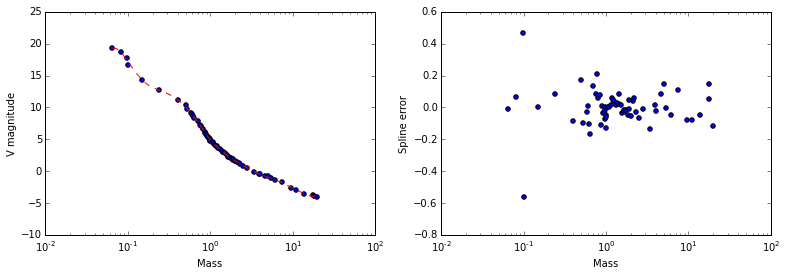

In [2]:
# Take a look at the relation between mass and V-band magnitude for main-sequence stars.
from Mamajek_Table import MamajekTable
import matplotlib.pyplot as plt

# Get the mamajek table. Sort by mass, and remove the NaNs
MT = MamajekTable()
df = MT.mam_df.dropna(subset=['Msun']).sort('Msun')
mass = df['Msun']
vmag = df['Mv']

# Interpolate the table with a smoothing spline.
from scipy.interpolate import UnivariateSpline
spline = UnivariateSpline(mass, vmag, s=0.9, ext=3)
mass_plot = np.linspace(min(mass), max(mass), 10000)
predicted = spline(mass_plot)
%matplotlib inline

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 4))
axes[0].set_xscale('log')
axes[1].set_xscale('log')

axes[0].scatter(mass, vmag)
axes[0].plot(mass_plot, predicted, 'r--')
axes[1].scatter(mass, vmag-spline(mass))

axes[0].set_xlabel('Mass')
axes[0].set_ylabel('V magnitude')
axes[1].set_xlabel('Mass')
axes[1].set_ylabel('Spline error')


In [27]:
10**((6-spline(30)+5)/5.)

949.04009426209382

Finally, we are ready to find put everything together. I will sample 1 million points from the Salpeter IMF between 1.5 and 20 $M_{\odot}$ and 1 million parallaxes drawn from the log-normal distribution I fit to Hipparchos data. I will then loop over various values of the mass-ratio ($q$) and find the fraction of stars with $V<6$ as a function of mass-ratio.

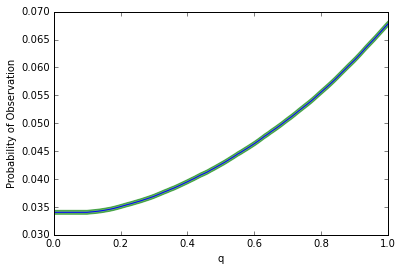

In [5]:
from __future__ import division
import IMF_utils
import HelperFunctions
reload(HelperFunctions)
from HelperFunctions import add_magnitudes, BinomialErrors
# Sample the distance and primary mass distributions, 
# and find the fraction that fall in my V-band limit as a function of q
N_total = 1e6

def Vmag(q, mass, d):
    """ Get the V-band magnitude as a function of mass-ratio (q), primary mass(mass),
        and distance (d)"""
    M1 = spline(mass)
    M2 = spline(q*mass)
    M_total = add_magnitudes(M1, M2)
    V = M_total + 5*np.log10(d) - 5
    return V

    

# Sample the distance through a log-normal parallax distribution (parameters fit to Hipparchos data)
#plx = scipy.stats.lognorm.rvs(loc=plx_loc, s=plx_shape, scale=plx_scale, size=N_total)
#plx[plx < 1e-5] = 1e-5
#distance = 1000. / plx

# Sample the distance such that a sphere around the Earth is uniformly distributed
distance = (np.random.uniform(size=N_total))**(1./3.) * 1000.0

# Sample the IMF
mass = IMF_utils.inverse_imf(np.random.uniform(size=N_total), mmin=1.5, mmax=20.0)

# Get the V_band magnitude
q = np.arange(0.0, 1.01, 0.01)
prob = np.zeros(q.size)
prob_low = np.zeros(q.size)
prob_high = np.zeros(q.size)
for i, qi in enumerate(q):
    V = Vmag(qi, mass, distance)
    prob[i], prob_low[i], prob_high[i] = BinomialErrors(len(V[V<6]), len(V))
    #prob[i] = len(V[V<6]) / len(V)

# We can't go all the way to zero because the V-magnitude interpolation starts extrapolating
# Instead, assume that P(obs|q<0.1) = P(obs|q)
idx = np.argmin((q - 0.1)**2)
prob[:idx] = prob[idx]
prob_low[:idx] = prob_low[idx]
prob_high[:idx] = prob_high[idx]
    
plt.plot(q, prob)
plt.fill_between(q, prob_low, prob_high, color='green', alpha=0.6)
plt.xlabel('q')
plt.ylabel('Probability of Observation')


         4           3           2
0.01853 x - 0.03797 x + 0.05758 x - 0.003972 x + 0.03382


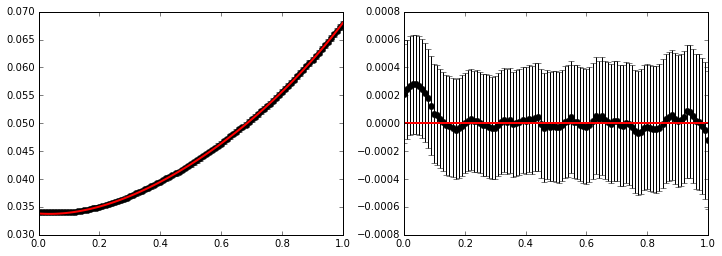

In [6]:
fit = np.poly1d(np.polyfit(q[q>0.1], prob[q>0.1], 4))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axes[0].errorbar(q, prob, yerr=(prob-prob_low, prob_high-prob), fmt='ko')
axes[0].plot(q, fit(q), 'r-', lw=2)

#axes[1].scatter(q, (prob - fit(q))/prob*100)
axes[1].errorbar(q, prob-fit(q), yerr=(prob-prob_low, prob_high-prob), fmt='ko')
axes[1].plot(q, np.zeros_like(q), 'r-', lw=2)
#axes[1].set_ylim((-0.001, 0.001))
print fit

In [8]:
fit.coeffs
e, d, c, b, a = fit.coeffs

array([ 0.01852787, -0.03797057,  0.05758326, -0.0039724 ,  0.03382178])

As expected, the probability of observing a binary system increases with mass-ratio. But that isn't *quite* what I need. What I need is the probability of getting a given mass-ratio, given that I observed it.

$$ P(q|obs) = \frac{P(obs|q)P(q)}{\int P(obs|q)P(q)dq} $$

But $P(q)$ is *precisely* what I am trying to measure in the first place! Grrr. Let's make sure this looks right by using the power law from De Rosa et al (2014).

0.0417088238087 6.44161369384e-09 0.0417088238096


/home/kgullikson/anaconda3/envs/python2/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: divide by zero encountered in power
  from IPython.kernel.zmq import kernelapp as app


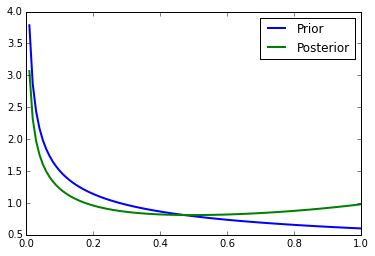

In [10]:
def prior(q, gamma=0.4):
    return (1-gamma)*q**(-gamma)

# Interpolate P(obs|q) (the plot above)
#Pobs = UnivariateSpline(q, prob, s=0, k=1)
Pobs = fit

# Integrate the bottom
from scipy.integrate import quad
denominator, den_err = quad(lambda x: Pobs(x)*prior(x), 0, 1)

# Calculate the true denominator analytically
e, d, c, b, a = fit.coeffs
gamma = 0.4
true_denominator = a + (1-gamma)*(b/(2-gamma) + c/(3-gamma) + d/(4-gamma) + e/(5-gamma))
print denominator, den_err, true_denominator

# Now, calculate P(q|obs) from Baye's theorem.
Pq = Pobs(q)*prior(q) / denominator

%matplotlib inline
plt.plot(q, prior(q), lw=2, label='Prior')
plt.plot(q, Pq, lw=2, label='Posterior')
plt.legend(loc='best')

That still gives the expected result, in that the mass-ratio distribution becomes skewed towards high mass-ratios. I will have to take an iterative approach in which I calculate the Malmquist bias from the current MRD parameter(s) and then repeat until the parameter no longer changes by much.

## How does changing the maximum volume change things?

<IPython.core.display.Javascript object>


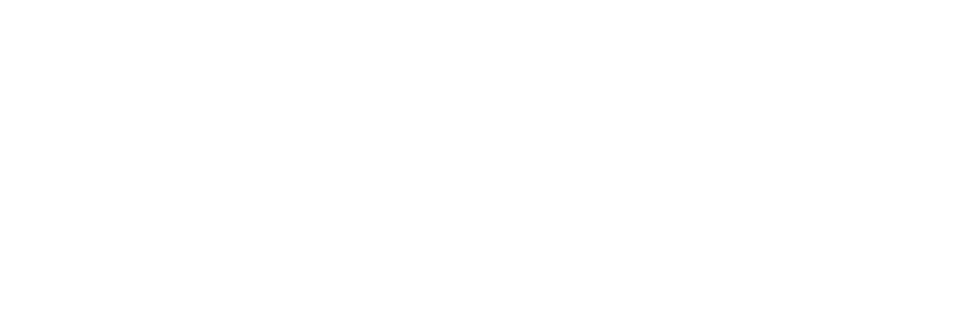

          5          4          3           2
-0.06156 x + 0.1651 x - 0.1543 x + 0.09221 x - 0.007085 x + 0.03594
array([-0.06156377,  0.16510332, -0.15427242,  0.09221468, -0.00708537,
        0.03594015])


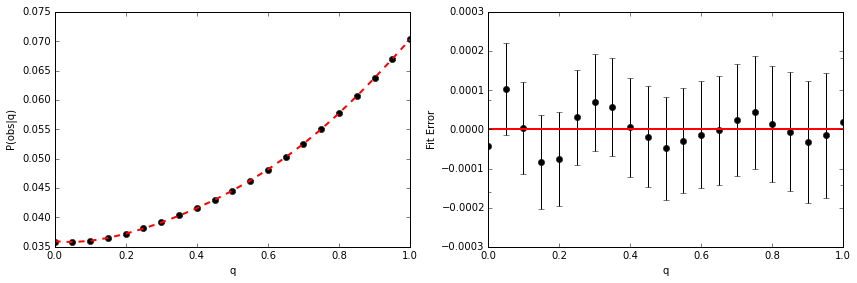

In [8]:
import IMF_utils
from HelperFunctions import add_magnitudes, BinomialErrors
from Mamajek_Table import MamajekTable
# Sample the distance and primary mass distributions, 
# and find the fraction that fall in my V-band limit as a function of q
N_total = 1e7

# Get the mamajek table. Sort by mass, and remove the NaNs
MT = MamajekTable()
df = MT.mam_df.dropna(subset=['Msun']).sort('Msun')
mass = df['Msun']
vmag = df['Mv']

# Interpolate the table with a smoothing spline.
from scipy.interpolate import UnivariateSpline
spline = UnivariateSpline(mass, vmag, s=0.9, ext=3) #The s parameter was fine-tuned. See the MalmquistBias notebook.

def Vmag(q, mass, d):
    """ Get the V-band magnitude as a function of mass-ratio (q), primary mass(mass),
        and distance (d)"""
    M1 = spline(mass)
    M2 = spline(q*mass)
    M_total = add_magnitudes(M1, M2)
    V = M_total + 5*np.log10(d) - 5
    return V    

def get_fit(Rmax, dq=0.03, N_total=1e7, fitorder=5):

    # Sample the distance such that a sphere around the Earth is uniformly distributed
    distance = (np.random.uniform(size=N_total))**(1./3.) * Rmax

    # Sample the IMF
    mass = IMF_utils.inverse_imf(np.random.uniform(size=N_total), mmin=1.5, mmax=20.0)

    # Get the V_band magnitude
    q = np.arange(0.0, 1.01, dq)
    prob = np.zeros(q.size)
    prob_low = np.zeros(q.size)
    prob_high = np.zeros(q.size)
    for i, qi in enumerate(q):
        V = Vmag(qi, mass, distance)
        prob[i], prob_low[i], prob_high[i] = BinomialErrors(len(V[V<6]), len(V))

    # Compute the sum
    total = prob.sum()
    #total = 1.0 
    
    # Fit the probability to a polynomial. 
    fit = np.poly1d(np.polyfit(q, prob/total, fitorder))
    return fit, q, prob/total, (prob-prob_low)/total, (prob_high-prob)/total
    
fit, q, prob, lowerr, higherr = get_fit(1000.0, dq=0.05)

# Make some plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axes[0].errorbar(q, prob, yerr=(lowerr, higherr), fmt='ko')
axes[0].plot(q, fit(q), 'r--', lw=2)
axes[0].set_xlabel('q')
axes[0].set_ylabel('P(obs|q)')

axes[1].errorbar(q, prob-fit(q), yerr=(lowerr, higherr), fmt='ko')
axes[1].plot(q, np.zeros_like(q), 'r-', lw=2)
axes[1].set_xlabel('q')
axes[1].set_ylabel('Fit Error')
#axes[1].set_ylim((-0.001, 0.001))
print fit
print fit.coeffs.__repr__()
plt.tight_layout()

In [9]:
Rmax_values = [100, 1000, 3000, 6000, 9000]
fit_list = []
fitorder = 5
n_iter = 3
coeffs_list = np.empty((len(Rmax_values)*n_iter, fitorder+1))
for i, Rmax in enumerate(Rmax_values):
    #fit_list.append([])
    for n in range(n_iter):
        print(Rmax, n)
        fit, _, _, _, _ = get_fit(Rmax, N_total=1e7, fitorder=fitorder, dq=0.05)
        coeffs_list[n + i*n_iter] = fit.coeffs
Rmax_list = np.array([np.ones(n_iter)*Rmax for Rmax in Rmax_values]).flatten()
df = pd.DataFrame(data=dict(Rmax=Rmax_list, a=coeffs_list[:, 5], b=coeffs_list[:, 4],
                            c=coeffs_list[:, 3], d=coeffs_list[:, 2], 
                            e=coeffs_list[:, 1], f=coeffs_list[:, 0]))
print(df)

(100, 0)
(100, 1)
(100, 2)
(1000, 0)
(1000, 1)
(1000, 2)
(3000, 0)
(3000, 1)
(3000, 2)
(6000, 0)
(6000, 1)
(6000, 2)
(9000, 0)
(9000, 1)
(9000, 2)
    Rmax         a         b         c         d         e         f
0    100  0.044871  0.001447 -0.010138  0.010513  0.032954 -0.023750
1    100  0.044875  0.001393 -0.009677  0.009337  0.034087 -0.024130
2    100  0.044867  0.001482 -0.010414  0.011311  0.032033 -0.023374
3   1000  0.035923 -0.006934  0.092154 -0.154584  0.164893 -0.061076
4   1000  0.035964 -0.006752  0.090400 -0.150031  0.159978 -0.059282
5   1000  0.035961 -0.006621  0.088150 -0.142772  0.151624 -0.056029
6   3000  0.031092 -0.010328  0.124781 -0.316872  0.475862 -0.218551
7   3000  0.030736 -0.009919  0.115522 -0.279669  0.430503 -0.200547
8   3000  0.030659 -0.007520  0.097717 -0.232536  0.380272 -0.182065
9   6000  0.030292 -0.006829  0.085890 -0.161406  0.267098 -0.129037
10  6000  0.030179 -0.007850  0.104098 -0.259899  0.421623 -0.199755
11  6000  0.030647 -0.002

In [10]:
funcs = [np.mean, np.std]
summary = df.groupby('Rmax').agg(dict(a=funcs, b=funcs, c=funcs, d=funcs, e=funcs, f=funcs))
summary

a                   c                   b                   e  \
          mean       std      mean       std      mean       std      mean   
Rmax                                                                         
100   0.044871  0.000004 -0.010076  0.000372  0.001441  0.000045  0.033025   
1000  0.035949  0.000023  0.090235  0.002007 -0.006769  0.000157  0.158832   
3000  0.030829  0.000231  0.112673  0.013755 -0.009256  0.001517  0.428879   
6000  0.030373  0.000244  0.077706  0.031298 -0.005691  0.002900  0.270490   
9000  0.031041  0.000220  0.143124  0.024249 -0.012222  0.002777  0.562531   

                       d                   f            
           std      mean       std      mean       std  
Rmax                                                    
100   0.001029  0.010387  0.000993 -0.023751  0.000378  
1000  0.006709 -0.149129  0.005957 -0.058796  0.002558  
3000  0.047816 -0.276359  0.042265 -0.200388  0.018243  
6000  0.149466 -0.153487  0.110584 -0.132643  0.065383  
9000  0.086509 -0.379477  0.072357 -0.259288  0.035102

<IPython.core.display.Javascript object>


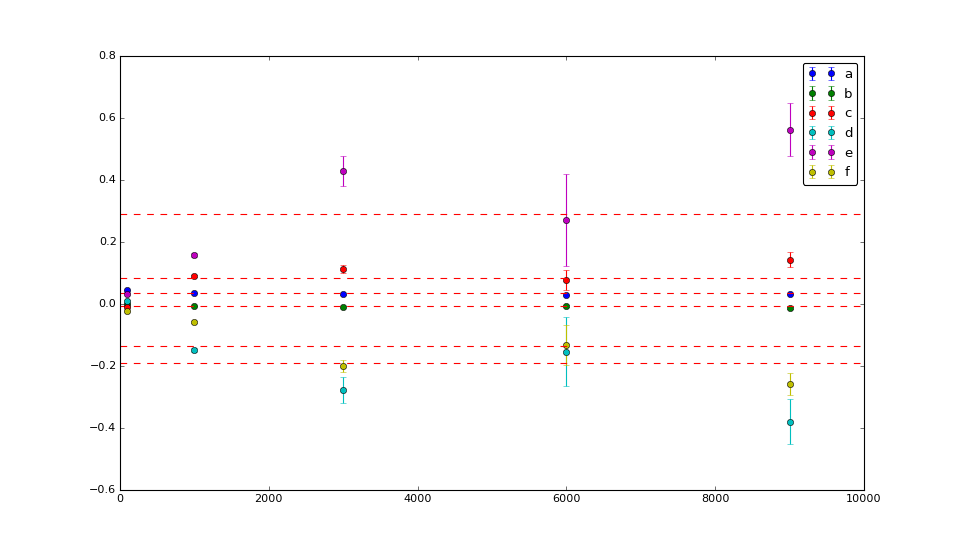

(0, 10000)

In [12]:
%matplotlib notebook
fig = plt.figure(figsize=(12,7))
for coeff_name in ['a', 'b', 'c', 'd', 'e', 'f']:
    subset = summary[coeff_name]
    plt.errorbar(summary.index, subset['mean'], yerr=subset['std'], fmt='o', label=coeff_name)
    plt.plot([0, 10000], [subset['mean'].mean()]*2, 'r--')

plt.legend(loc='best', fancybox=True)
plt.xlim((0, 10000))

(0, 10000)

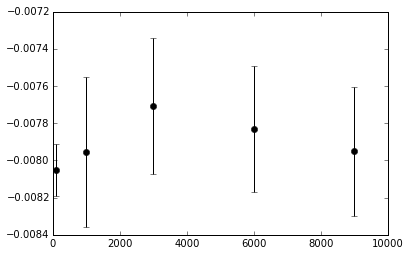

In [64]:
subset = summary.b
plt.errorbar(summary.index, subset['mean'], yerr=subset['std'], fmt='ko')
plt.xlim((0, 10000))

## Malmquist bias also affects the overal binary frequency I measure!
Since binary stars will be systematically biased towards lower magnitudes, my survey is also biased towards any binary stars. That was kind of why I did it as a magnitude limit in the first place, but I will still need to correct for that!

In [34]:
Rmax_list = np.array([np.ones(n_iter)*Rmax for Rmax in Rmax_values])

In [35]:
Rmax_list.flatten().shape, coeffs_list.shape

((15,), (15, 6))

In [37]:
coeffs_list[:, 0].shape

(15,)